# Recommendation systems with Deep neural network

### **2019/07/01 SK하이닉스-KAIST 기계학습 교육**

***Tip> shotcuts for Jupyter Notebook***
* Shift + Enter : run cell and select below

#### Objective> Train deep neural network (autoencoder) to complete movie rating matrix
<img src="img/fig1.png" alt="fig1" width="700"/>
<center>Fig. 1 Item-based autoencoder </center>

- #### Loss function

$$L(M, \hat{M})=\sum_{(i,j)\in E}(M_{ij}-\hat{M}_{ij})^2 + \lambda\sum_{i=1}^{3}\lVert W_i\rVert^2_2$$
<br/>
- #### Update weight and bias
$$\underset{W, b}{\text{argmin}}\hspace{0.2em} L(M, \hat{M})$$

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time

## 1. Prepare data
### MovieLens Dataset (<a href=https://grouplens.org/datasets/movielens/>ref.</a>)
We use "MovieLens Latest Datasets" consisting of 100,000 ratings applied to 9,000 movies by 600 users. Last updated 9/2018.

### Fetch MovieLens data

In [2]:
rating = pd.read_csv('./data/ratings.csv')
rating.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [3]:
rating.iloc[:,2].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

### Ratings statistics
Count the number of movies with identical rating.

In [4]:
rating.set_index(["userId", "timestamp","rating"]).count(level="rating").rename({'movieId': 'The number of movies'}, axis='columns')

,The number of movies
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Count the number of users and movies and check the sparsity

In [5]:
n_user = len(rating['userId'].unique())
n_movie = len(rating['movieId'].unique())
n_rating = len(rating['rating'])
print("[*] %d users & %d movies" % (n_user, n_movie))
print("[*] Sparsity: %.2f%%" % (n_rating / (n_user * n_movie) * 100))

[*] 610 users & 9724 movies
[*] Sparsity: 1.70%


### Movie list
See the movie list including movies' title and genres.

In [6]:
movielist = pd.read_csv('./data/movies.csv')
movielist.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Drop **"timestamp"** which looks useless.

In [7]:
rating.drop(['timestamp'], axis=1, inplace=True)
rating.tail()

,userId,movieId,rating
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0
100835,610,170875,3.0


Scale **"movieId"** in between 0 and 9741, **"userId"** in between 0 and 609

In [8]:
rating['movieId'], _ = pd.factorize(rating['movieId'])
rating['userId'], _ = pd.factorize(rating['userId'])
rating.tail()

,userId,movieId,rating
100831,609,3120,4.0
100832,609,2035,5.0
100833,609,3121,5.0
100834,609,1392,5.0
100835,609,2873,3.0


### Item-based autoencoder
Transpose the rating matrix

In [9]:
rating = rating[['movieId', 'userId', 'rating']]
rating.head()

,movieId,userId,rating
0,0,0,4.0
1,1,0,4.0
2,2,0,4.0
3,3,0,5.0
4,4,0,5.0


### Split the ratings for training and test
Training : Test = 9 : 1

In [10]:
trainIdx = np.random.choice(range(n_rating), int(n_rating * 0.9), replace=False)
dataTrain = rating.iloc[trainIdx]

testIdx = np.setdiff1d(range(n_rating), trainIdx)
dataTest = rating.iloc[testIdx]

In [11]:
ratingTrain = np.asarray(dataTrain)
ratingTest = np.asarray(dataTest)
d1, d2 = np.max(ratingTrain[:, 0]) + 1, np.max(ratingTrain[:, 1] + 1)

## 2. Build a Graph
We use "tf.sparse_tensor_dense_matmul()" function instead of  "tf.layers.dense( )" function, because of the sparse input and regularization.

In [12]:
def autoencoder(_X, _units, _l2_lambda, _n_ratings, _is_training):
    w_init = tf.initializers.variance_scaling()
    b_init = tf.constant_initializer(0.)
    
    ## Encoder
    '1st Hidden layer'
    w1 = tf.get_variable('weight1', [d2, _units[0]], initializer=w_init)
    b1 = tf.get_variable('biases1', [_units[0]], initializer=b_init)
    h1_b = tf.sparse_tensor_dense_matmul(_X, w1) + b1
    h1 = tf.layers.batch_normalization(h1_b)
    h1 = tf.nn.relu(h1)

    '2nd Hidden layer'
    w2 = tf.get_variable('weight2', [_units[0], _units[1]], initializer=w_init)
    b2 = tf.get_variable('biases2', [_units[1]], initializer=b_init)
    h2_b = tf.matmul(h1, w2) + b2
    h2 = tf.layers.batch_normalization(h2_b)
    h2 = tf.nn.sigmoid(h2)
    
    ## Decoder
    w3 = tf.get_variable('weight3', [_units[1], d2], initializer=w_init)
    
    yhat = tf.matmul(h2, w3)
    out = tf.gather_nd(yhat, _X.indices)

    loss = tf.reduce_sum(tf.pow(out - _X.values, 2)) / _n_ratings
    
    
    ''' L2 regularization '''
    all_var = [var for var in tf.trainable_variables() ]
    l2_losses = []
    for var in all_var:
        if var.op.name.find('weight') == 0:
            l2_losses.append(tf.nn.l2_loss(var))
    
    losses = loss + _l2_lambda * tf.reduce_sum(l2_losses)
    
    return yhat, losses

### Set hyperparameters
- ***n_epochs*** : The number of epochs
- ***lr*** : Learning rate for gradient descent
- ***l2_lambda*** : regularization parameter
- ***n_units*** : The number of units for each hidden layer

In [13]:
"""parameters"""
n_epochs = 1000
lr = 0.1
l2_lambda = 0.003
n_units = [100, 50]
n_ratings = len(ratingTrain)
display_step = n_epochs / 10

### Placeholder for sparse input data

In [14]:
# tf Graph input
X = tf.sparse_placeholder(dtype=tf.float32)
is_training = tf.placeholder(dtype=tf.bool)

### Use the GradientDescentOptimizer

In [15]:
pred, cost = autoencoder(X, n_units, l2_lambda, n_ratings, is_training)
global_step = tf.Variable(0, trainable=False)
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost, global_step=global_step)

W0701 14:52:48.343518 140593435666176 deprecation.py:323] From <ipython-input-12-ee4b962bcd37>:10: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
W0701 14:52:48.455386 140593435666176 deprecation.py:323] From /mnt/home/skhynix/.conda/envs/SK_Week1_py3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 3. Training
### Create a tensorflow session
Tensorflow operations must be executed in the session. The only one session is activated.

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=4)
    print("START OPTIMIZATION\n")
    start_time = time.time()
    losses = []
    for epoch in  range(n_epochs + 1):
        feed = {X: (ratingTrain[:, 0:2], ratingTrain[:, 2], [d1, d2]),
               is_training: True}
        _, avg_cost = sess.run((optimizer, cost), feed_dict = feed)
        losses.append(np.sqrt(avg_cost))

        # DISPLAY
        if epoch % display_step == 0:
            duration = float(time.time() - start_time)
            print(" [*] Epoch: %05d/%05d cost: %2e (duration: %.3fs)" % (epoch, n_epochs, np.sqrt(avg_cost), duration))
            start_time = time.time()
            
            saver.save(sess, './log/recommender')
        
    print("\nOptimization Finished!")

START OPTIMIZATION

 [*] Epoch: 00000/01000 cost: 3.818631e+00 (duration: 0.121s)
 [*] Epoch: 00100/01000 cost: 1.870533e+00 (duration: 4.388s)
 [*] Epoch: 00200/01000 cost: 1.605014e+00 (duration: 4.402s)
 [*] Epoch: 00300/01000 cost: 1.503550e+00 (duration: 4.513s)
 [*] Epoch: 00400/01000 cost: 1.448006e+00 (duration: 4.493s)
 [*] Epoch: 00500/01000 cost: 1.410827e+00 (duration: 4.474s)
 [*] Epoch: 00600/01000 cost: 1.381924e+00 (duration: 4.341s)
 [*] Epoch: 00700/01000 cost: 1.357159e+00 (duration: 4.383s)
 [*] Epoch: 00800/01000 cost: 1.334982e+00 (duration: 4.354s)
 [*] Epoch: 00900/01000 cost: 1.314983e+00 (duration: 4.337s)
 [*] Epoch: 01000/01000 cost: 1.296848e+00 (duration: 4.567s)

Optimization Finished!


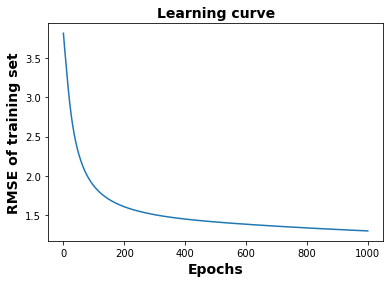

In [17]:
plt.plot(losses)
plt.title("Learning curve", fontsize=14, fontweight='bold')
plt.xlabel("Epochs", fontsize=14, fontweight='bold')
plt.ylabel("RMSE of training set", fontsize=14, fontweight='bold')
plt.show()

## 4. Test

In [18]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./log/recommender.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./log'))
    feed = {X: (ratingTrain[:, 0:2], ratingTrain[:, 2], [d1, d2]), 
           is_training: False}
    Pred = sess.run(pred, feed_dict=feed)

    idxTest = (ratingTest[:, 0].astype(int), ratingTest[:, 1].astype(int))
    idxTrain = (ratingTrain[:, 0].astype(int), ratingTrain[:, 1].astype(int))

    RMSE_Test = np.sqrt(np.sum((Pred[idxTest] - ratingTest[:, 2]) ** 2) / len(ratingTest[:, 0]))
    RMSE_Train = np.sqrt(np.linalg.norm(Pred[idxTrain] - ratingTrain[:, 2]) ** 2 / len(ratingTrain[:, 0]))

    print("[*] RMSE Test: %.4e" % RMSE_Test)
    print("[*] RMSE Train %.4e" % RMSE_Train)

W0701 14:53:33.704758 140593435666176 deprecation.py:323] From /mnt/home/skhynix/.conda/envs/SK_Week1_py3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


[*] RMSE Test: 9.0906e-01
[*] RMSE Train 8.9526e-01


## Report</br>

### 1. Momentum Optimizer
Use the "MomentumOptimizer( )" instaed of the GradientDescentOptimizer and compare the RMSE learning curves of the two optimizers. When you use MomentumOptimizer, set the momuentum at 0.9 and adjust the learning rate.

### 2. Batch normalization
Apply "batch normalization" to the 1st and 2nd hidden layers, and compare the resulting RMSE learning curves with those obtained above.<br/>
*Hint)* tf.layers.batch_normalization( )

## 3. Weigth decay
Change weight decay ratio (l2_lambda) and check the RMSE for both train and test. When there is no weight decay (l2_lambda = 0), what problems is occured?